# data : House Price

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',family='Malgun Gothic')

from scipy import stats
from scipy.stats import skew

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
house_df_org = pd.read_csv('C:/Users/Park/_Python_data/houseprice/train.csv')
house_df = pd.read_csv('C:/Users/Park/_Python_data/houseprice/train.csv')

print('데이터 세트의 shape :',house_df.shape)
print('-'*30)
print('데이터 type \n', house_df.dtypes.value_counts())
print('-'*30)
house_null = house_df.isnull().sum()
print('null 데이터 \n',house_null[house_null>0].sort_values(ascending=False))

데이터 세트의 shape : (1460, 81)
------------------------------
데이터 type 
 object     43
int64      35
float64     3
dtype: int64
------------------------------
null 데이터 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


# 1. 데이터 전처리

### (1) 결측값 처리

* null 값이 1,000 이상인 PoolQC, MiscFeature, Alley, Fence 변수와 불필요 변수 ID, FireplaceQu 제거

In [3]:
house_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id','FireplaceQu'], inplace=True, axis=1)

### (2) 데이터 인코딩


- 수치형 데이터와 문자형 데이터의 컬럼명 분할
- 제거하지 않은 변수의 null 값은 평균값 및 NaN으로 대체
- 원핫인코딩(pd.get_dummies는 결측값을 인코딩하지 않는다는 점에서 차이가 있다)

In [4]:
numeric_df = house_df.select_dtypes(include='number')
numeric_df.fillna(numeric_df.mean(),inplace=True)
categorical_df = house_df.select_dtypes(include='object')
categorical_columns = house_df.select_dtypes(include='object').columns

cat_pipeline = Pipeline([('imputer',SimpleImputer(strategy = 'constant', fill_value='None')),
                         ('encoder',OneHotEncoder(sparse = False, handle_unknown = 'ignore'))])

categorical_df = cat_pipeline.fit_transform(categorical_df)
cat_columns = cat_pipeline['encoder'].get_feature_names(categorical_columns)
categorical_df = pd.DataFrame(categorical_df, columns = cat_columns)
house_df = pd.concat([numeric_df,categorical_df],axis=1)
house_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### (3) target 데이터 로그 변환

* target 변수의 분포 확인
* log1p()로의 변환

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

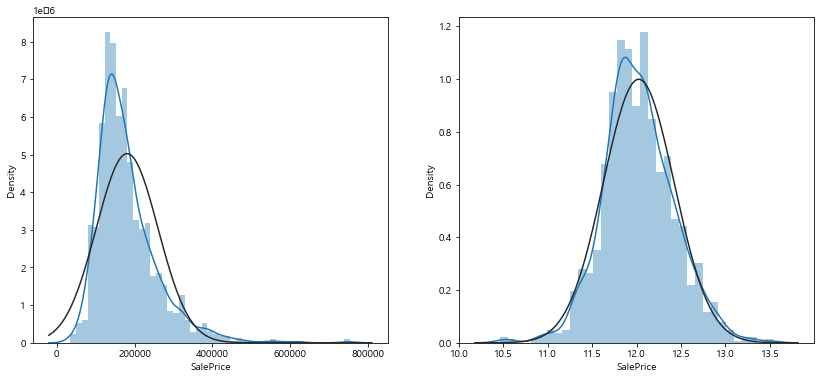

In [5]:
X=house_df.drop(['SalePrice'],axis=1)
y=house_df.SalePrice
y= np.log1p(y)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.distplot(np.expm1(y),fit=stats.norm)
plt.subplot(1,2,2)
sns.distplot(y, fit=stats.norm)

# 2. 성능 평가지표 함수 구축

In [6]:
# log 변환 시 NaN 등의 이슈로 log()가 아닌 log1p(자연로그)를 이용해 RMSLE 계산
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# RMSE 계산
def rmse(y,pred):
    rmse = np.sqrt(mean_squared_error(y,pred))
    return rmse

# MSE, RMSE, RMSLE, MAE 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mse_val = mean_squared_error(y,pred)
    mae_val = mean_absolute_error(y,pred)
    r2_val = r2_score(y,pred)
    print('RMSLE : {0:.3f}, RMSE : {1:.3f}, MSE : {2:.3f}, MAE : {3:.3f}, R2 : {4:.3f}'.format(rmsle_val, rmse_val, mse_val, mae_val,r2_val))
    
# 모델 학습 및 예측과 성능 평가 함수 생성
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):  # 디폴드값을 설정하는 것
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    # 만약 로그값이 존재하면 원래 스케일로 반환하라
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test,pred)

# 3. 모델 구축

### (1) 모델 구축 및 성능 평가

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=156)

lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_reg = ElasticNet()
model = [lr_reg,ridge_reg,lasso_reg,elastic_reg]

for model in model:
    get_model_predict(model,X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE : 0.132, RMSE : 22119.836, MSE : 489287147.941, MAE : 14816.571, R2 : 0.927
### Ridge ###
RMSLE : 0.128, RMSE : 25746.252, MSE : 662869467.904, MAE : 15420.770, R2 : 0.902
### Lasso ###
RMSLE : 0.176, RMSE : 34746.302, MSE : 1207305531.241, MAE : 22342.712, R2 : 0.821
### ElasticNet ###
RMSLE : 0.171, RMSE : 35137.543, MSE : 1234646894.920, MAE : 21468.217, R2 : 0.817


### (2) 회귀계수 시각화

* 회귀계수의 값을 반환하는 함수 생성

In [8]:
def get_top_bottom_coef(model, n=10):
    # coef_속성을 기반으로 Series 객체 생성. index는 컬럼명
    coef = pd.Series(model.coef_, index =X.columns)
    
    # 상위 10개, 하위 10개의 회귀계수 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

* 모델 별 회귀계수 시각화

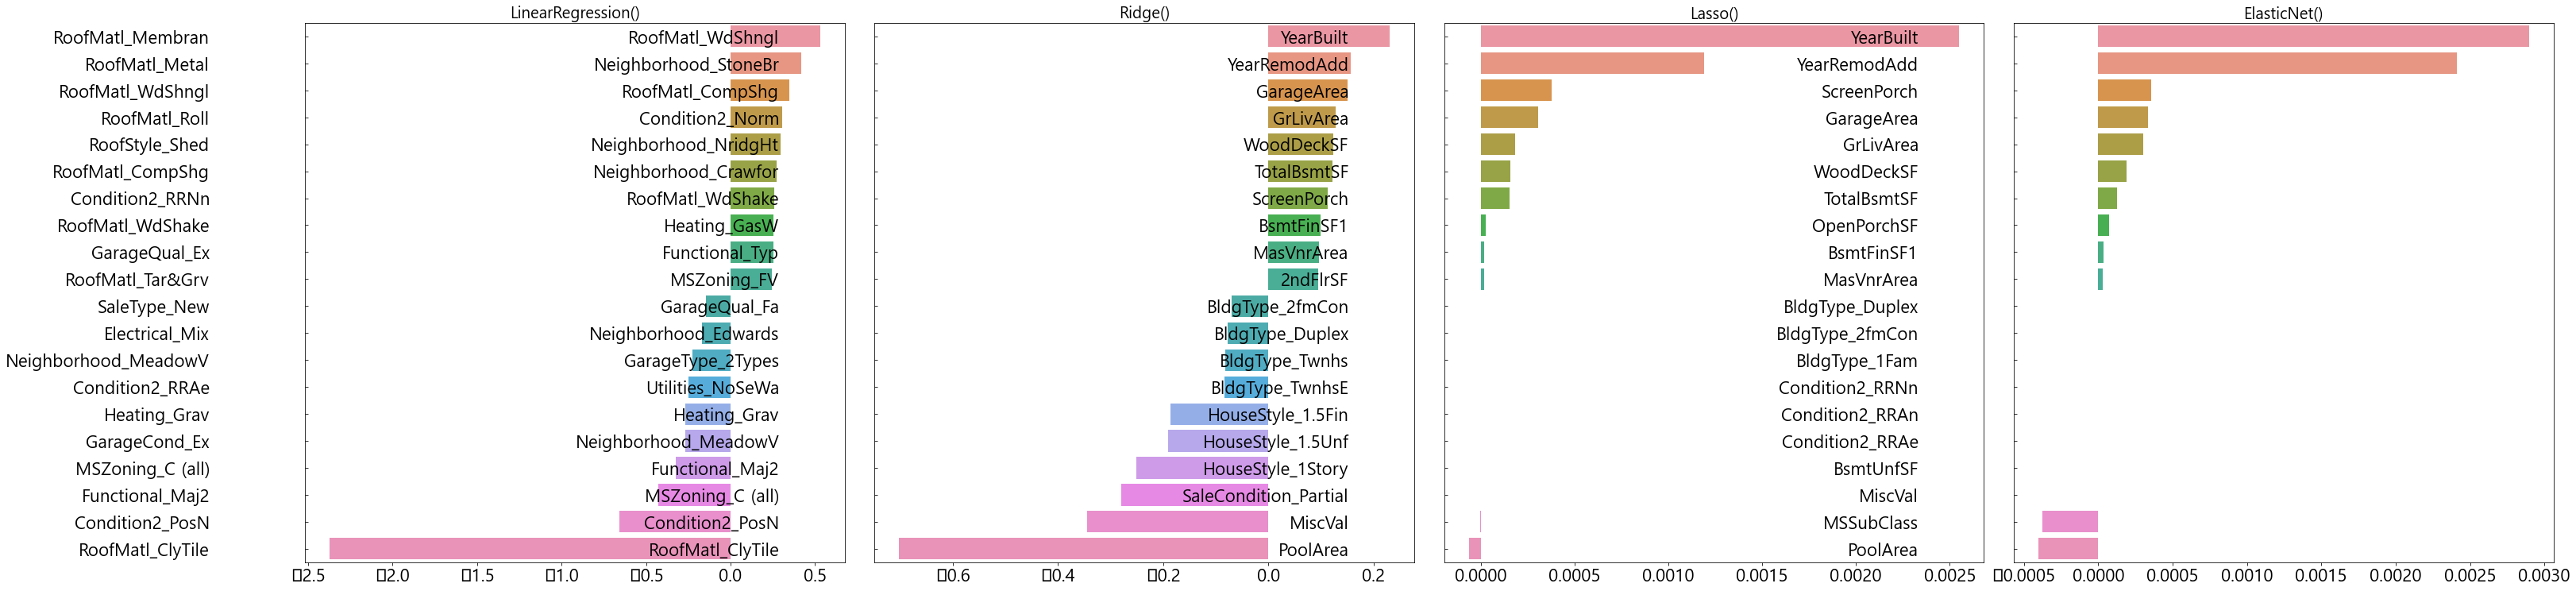

In [9]:
model = [lr_reg,ridge_reg,lasso_reg,elastic_reg]

def visualize_coef(model):
    fig, axes = plt.subplots(nrows = 1, ncols=4, figsize=(40,10))
    # 플롯 간 간격 조정
    fig.tight_layout()
    # 입력 인자로 받은 list객체인 model에서 차례로 model을 추출해 회귀계수 시각화
    for i_num, model in enumerate(model):
        # 상위 10개, 하위 10개 회귀계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high,coef_low])
        # bar plot으로 표현
        axes[i_num].set_title(model,size=20)
        axes[i_num].tick_params(axis='y',direction='in',pad=120)
        for label in (axes[i_num].get_xticklabels()+axes[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values,y=coef_concat.index, ax=axes[i_num])
        
visualize_coef(model)

* lasso와 elasticnet의 회귀계수가 몇개를 제외하고는 너무 작다
* 혹시 train, test 세트로 분리해서 이러한 결과가 출력되었는지 확인하기 위해 분할하지 않고 교차검증을 실시한다.
* 교차검증의 결과값으로 RMSLE를 출력하는 함수를 생성한다.(로그값이 씌워져 있기 때문에 RMSE계산)

### (3) 교차검증 실시
* 데이터를 분할하지 않고 실시한다.

In [10]:
def get_cross_val_score(model):
    
    for model in model:
        rmse_list = np.sqrt(-cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error'))
        rmse_mean = np.mean(rmse_list)
        print('\n{0} CV RMSLE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('{0} CV 평균 RMSLE 값 : {1}'.format(model.__class__.__name__, np.round(rmse_mean,3)))
    
get_cross_val_score(model)
    


LinearRegression CV RMSLE 값 리스트 : [1.340000e-01 4.604636e+03 1.670000e-01 3.813588e+03 1.980000e-01]
LinearRegression CV 평균 RMSLE 값 : 1683.745

Ridge CV RMSLE 값 리스트 : [0.117 0.155 0.142 0.117 0.189]
Ridge CV 평균 RMSLE 값 : 0.144

Lasso CV RMSLE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSLE 값 : 0.198

ElasticNet CV RMSLE 값 리스트 : [0.155 0.198 0.166 0.172 0.257]
ElasticNet CV 평균 RMSLE 값 : 0.19


* LinearRegression 값만 책과 다르게 나왔는데, 책에는 0.155로 표시되어있음. 고로 해당 결과는 무시한다.
* 이에 Lasso와 ElasticNet에 최적하이퍼파라미터 탐색을 실시한다.

### (4) 최적 하이퍼파라미터 추정

In [11]:
model = [ridge_reg,lasso_reg,elastic_reg]

def print_best_param(model,param):
    grid_model = GridSearchCV(model, param_grid=param, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5CV 시 최적 평균 RMSLE값 : {1},최적 ALPHA : {2}'.format(model.__class__.__name__,np.round(rmse,4),grid_model.best_params_))
    return grid_model.best_estimator_
ridge_param = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_param = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
elastic_param = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

print_best_param(ridge_reg, ridge_param)
print_best_param(lasso_reg, lasso_param)
print_best_param(elastic_reg, elastic_param)

Ridge 5CV 시 최적 평균 RMSLE값 : 0.1418,최적 ALPHA : {'alpha': 12}
Lasso 5CV 시 최적 평균 RMSLE값 : 0.142,최적 ALPHA : {'alpha': 0.001}
ElasticNet 5CV 시 최적 평균 RMSLE값 : 0.1394,최적 ALPHA : {'alpha': 0.001}


ElasticNet(alpha=0.001)

### (5) 최적 하이퍼파라미터로 모델 구축

### LinearRegression ###
RMSLE : 0.132, RMSE : 22119.836, MSE : 489287147.941, MAE : 14816.571, R2 : 0.927
### Ridge ###
RMSLE : 0.124, RMSE : 27571.418, MSE : 760183065.854, MAE : 15496.072, R2 : 0.887
### Lasso ###
RMSLE : 0.120, RMSE : 25896.008, MSE : 670603223.285, MAE : 15120.387, R2 : 0.900
### ElasticNet ###
RMSLE : 0.119, RMSE : 24845.346, MSE : 617291215.597, MAE : 14696.282, R2 : 0.908


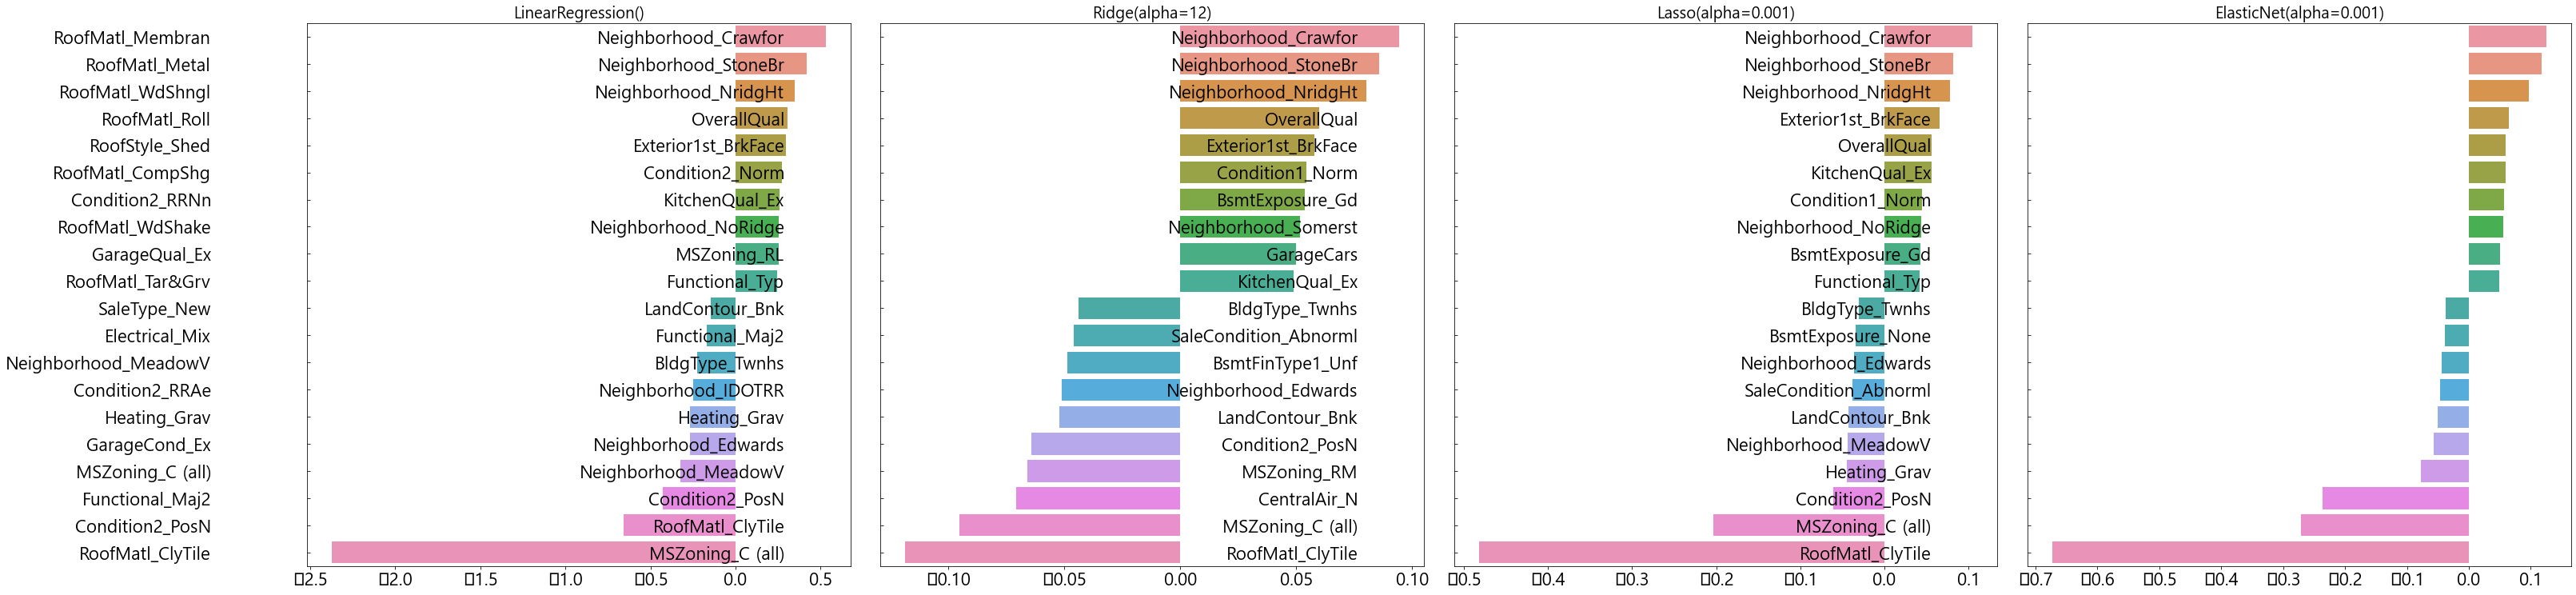

In [12]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

elastic_reg = ElasticNet(alpha=0.001)
elastic_reg.fit(X_train,y_train)

# 시각화 결과 출력
model = [lr_reg,ridge_reg,lasso_reg,elastic_reg]
visualize_coef(model)

# 성능평가지표 출력
for model in model:
    get_model_predict(model,X_train, X_test, y_train, y_test, is_expm1=True)

# 4. 데이터 추가 가공

### (1) 데이터 왜곡 분포 확인  및 로그변환
* 일반적으로 1보다 큰 값을 가질 경우 왜곡 정도가 높다고 판단
* 해당 문제에서는 skew가 1보다 큰 값의 변수를 추출하여 로그변환 실시
* 이때 주의할 점은 인코딩이 되지 않은 데이터를 대상으로 skew()함수를 적용해야 한다.

In [13]:
# object 타입이 아닌 변수 추출
feature_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df_df 칼럼 index를 []로 입력하면 해당하는 컬럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_feature = house_df[feature_index].apply(lambda x : skew(x))
# skew가 1 이상인 컬럼 추출
skew_feature_top = skew_feature[skew_feature>1]
print(skew_feature_top.sort_values(ascending=False))

RoofMatl_Membran       38.170678
Exterior1st_CBlock     38.170678
Exterior2nd_CBlock     38.170678
Condition2_RRAn        38.170678
Exterior1st_ImStucc    38.170678
                         ...    
MSSubClass              1.406210
1stFlrSF                1.375342
GrLivArea               1.365156
GarageFinish_Fin        1.210544
GarageType_Detchd       1.064557
Length: 217, dtype: float64


* 왜도가 1 이상인 컬럼 대상으로 로그변환

In [14]:
house_df[skew_feature_top.index]=np.log1p(house_df[skew_feature_top.index])

* 로그 변환 후 다시 인코딩을 실시한다. 이때 결측값은 이미 채워져 있기 때문에 원핫인코딩만 실시한다.
* 문자형 변수와 숫자형 변수를 분리하여 실시한다.
* 결측값을 다시 채워준 후 인코딩 실시

In [15]:
num_columns = []
cate_columns = []
num = ['int16','int32','int64','float16','float32','float64']
for i in house_df.columns:
    if house_df[i].dtype in num:
        num_columns.append(i)
    else :
        cate_columns.append(i)

# 문자형과 숫자형 데이터 분할
house_df_num = house_df[num_columns]
house_df_cate = house_df[cate_columns]

# 결측값 대체
house_df_num.fillna(house_df_num.mean(),inplace=True)
house_df_cate.fillna('NaN',axis=1,inplace=True)

# 인코딩 후 문자형과 숫자형 데이터 결합
one_hot = OneHotEncoder(sparse=False)
encoder = one_hot.fit_transform(house_df_cate)
house_df_enco = pd.DataFrame(encoder, columns=one_hot.get_feature_names(cate_columns))

house_df_enco = pd.concat([house_df_num,house_df_enco],axis=1)

* 모델 재구축

In [16]:
X = house_df_enco.drop(['SalePrice'],axis=1)
y = house_df_enco.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=156)

ridge_param = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_param = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
elastic_param = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

print_best_param(ridge_reg, ridge_param)
print_best_param(lasso_reg, lasso_param)
print_best_param(elastic_reg, elastic_param)

Ridge 5CV 시 최적 평균 RMSLE값 : 0.1276,최적 ALPHA : {'alpha': 8}
Lasso 5CV 시 최적 평균 RMSLE값 : 0.1281,최적 ALPHA : {'alpha': 0.001}
ElasticNet 5CV 시 최적 평균 RMSLE값 : 0.1247,최적 ALPHA : {'alpha': 0.001}


ElasticNet(alpha=0.001)

### LinearRegression ###
RMSLE : 0.128, RMSE : 25137.788, MSE : 631908361.024, MAE : 15218.395, R2 : 0.906
### Ridge ###
RMSLE : 0.122, RMSE : 27843.473, MSE : 775258985.229, MAE : 14938.053, R2 : 0.885
### Lasso ###
RMSLE : 0.121, RMSE : 28307.646, MSE : 801322798.143, MAE : 15092.240, R2 : 0.881
### ElasticNet ###
RMSLE : 0.119, RMSE : 27139.982, MSE : 736578629.059, MAE : 14708.608, R2 : 0.891


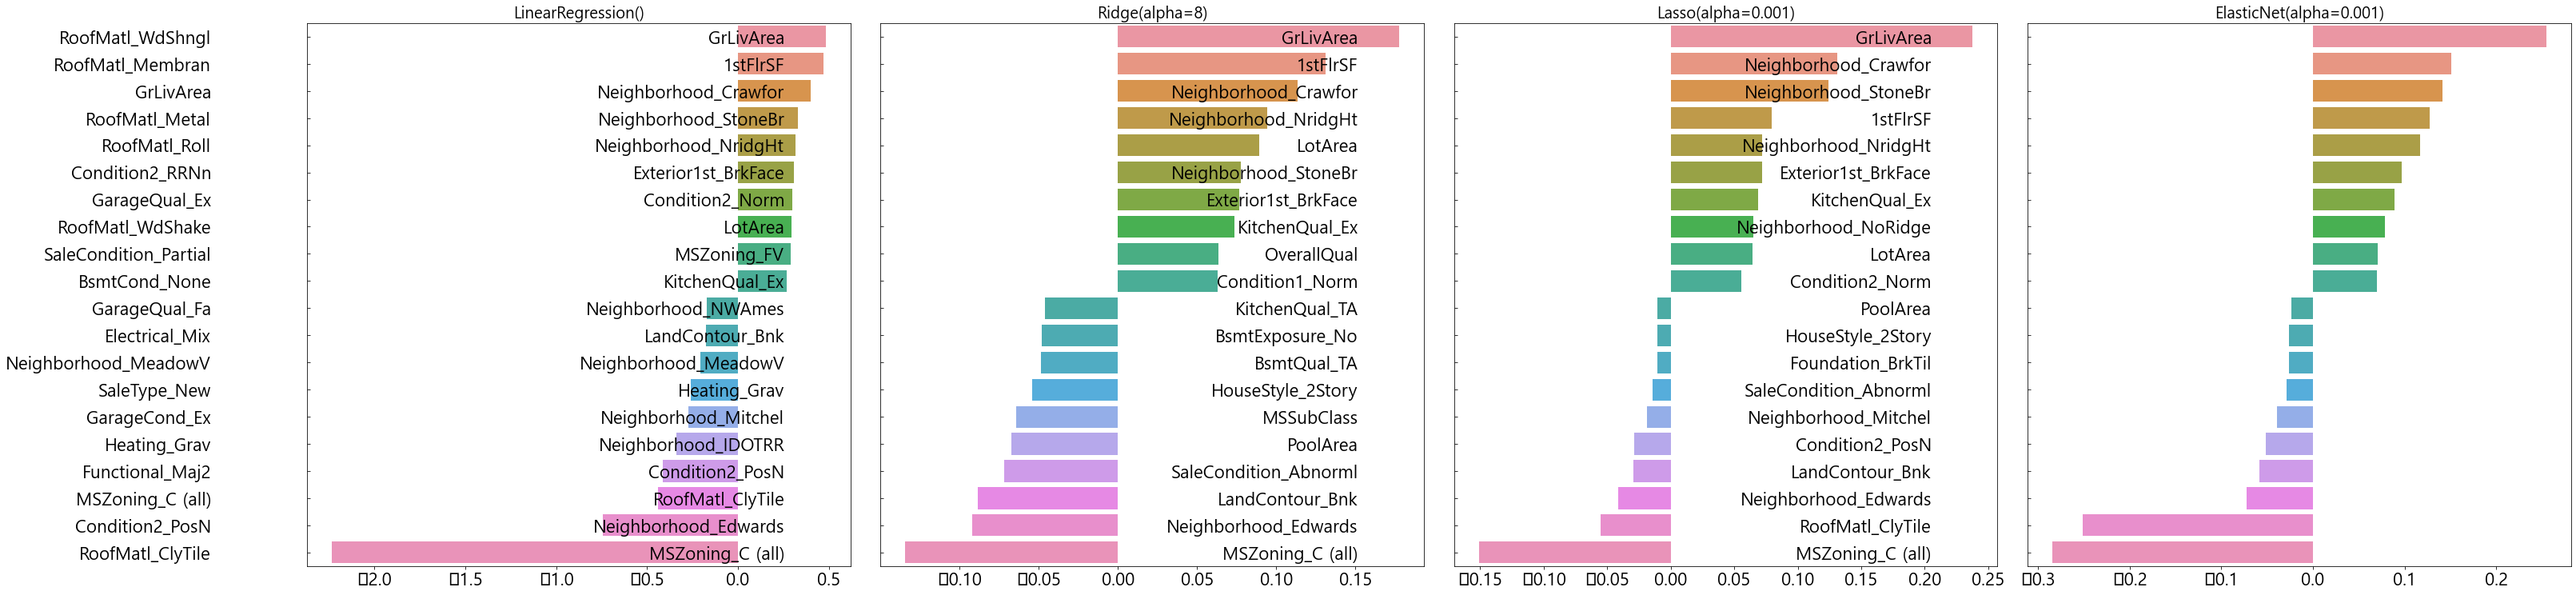

In [17]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

elastic_reg = ElasticNet(alpha=0.001)
elastic_reg.fit(X_train,y_train)

# 시각화 결과 출력
model = [lr_reg,ridge_reg,lasso_reg,elastic_reg]
visualize_coef(model)

# 성능평가지표 출력
for model in model:
    get_model_predict(model,X_train, X_test, y_train, y_test, is_expm1=True)

* 교차검증의 결과 RMSLE는 개선이 되었다.
* 최적 알파값을 통해 학습시킨 결과 RMSLE는 약간 개선되었지만 다른 지표는 오히려 악화되었다.

### (2) 이상치 탐색

* 먼저 각 모델에서 가장 큰 회귀계수를 갖는 GrLivArea를 살펴보자
* 타겟 데이터와 산점도를 그려본다.

Text(0, 0.5, 'SalePrice')

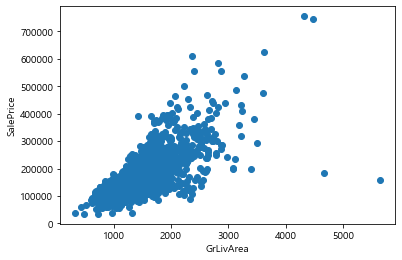

In [18]:
plt.scatter(house_df_org.GrLivArea, house_df_org.SalePrice)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

* 주거공간의 크기와 가격은 당연히 양의 상관관계가 있으니 직관적으로 상관관계가 높음을 알 수 있다.
* 따라서 우측 하단의 점은 상관관계에서 벗어난 이상치 자료이다.
* 이에 4,000평방피트 이상에서 500,000달러 이하의 데이터는 이상치로 간주하고 삭제한다.

In [19]:
# 데이터가 모두 로그변환 및 전처리 되었으니 조건값에 로그값을 적용하여 계산
con1 = house_df_enco['GrLivArea'] > np.log1p(4000)
con2 = house_df_enco['SalePrice'] < np.log1p(500000)
# 이상치 인덱스 넘버 출력
outlier_index = house_df_enco[con1 & con2].index

print('이상치 레코드 : ',outlier_index.values)
print('이상치 삭제 전 shape :', house_df_enco.shape)

# 이상치 인덱스 넘버 삭제
house_df_enco = house_df_enco.drop(outlier_index,axis=0)
print('이상치 삭제 후 shape :', house_df_enco.shape)

이상치 레코드 :  [ 523 1298]
이상치 삭제 전 shape : (1460, 281)
이상치 삭제 후 shape : (1458, 281)


In [20]:
X = house_df_enco.drop(['SalePrice'],axis=1)
y = house_df_enco.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=156)

ridge_param = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_param = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
elastic_param = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

print_best_param(ridge_reg, ridge_param)
print_best_param(lasso_reg, lasso_param)
print_best_param(elastic_reg, elastic_param)

Ridge 5CV 시 최적 평균 RMSLE값 : 0.1121,최적 ALPHA : {'alpha': 5}
Lasso 5CV 시 최적 평균 RMSLE값 : 0.1149,최적 ALPHA : {'alpha': 0.001}
ElasticNet 5CV 시 최적 평균 RMSLE값 : 0.1113,최적 ALPHA : {'alpha': 0.001}


ElasticNet(alpha=0.001)

### LinearRegression ###
RMSLE : 0.129, RMSE : 21670.201, MSE : 469597632.134, MAE : 14826.523, R2 : 0.934
### Ridge ###
RMSLE : 0.101, RMSE : 18229.577, MSE : 332317494.616, MAE : 12402.379, R2 : 0.953
### Lasso ###
RMSLE : 0.100, RMSE : 18681.290, MSE : 348990580.345, MAE : 12535.566, R2 : 0.951
### ElasticNet ###
RMSLE : 0.100, RMSE : 18094.840, MSE : 327423221.408, MAE : 12154.356, R2 : 0.954


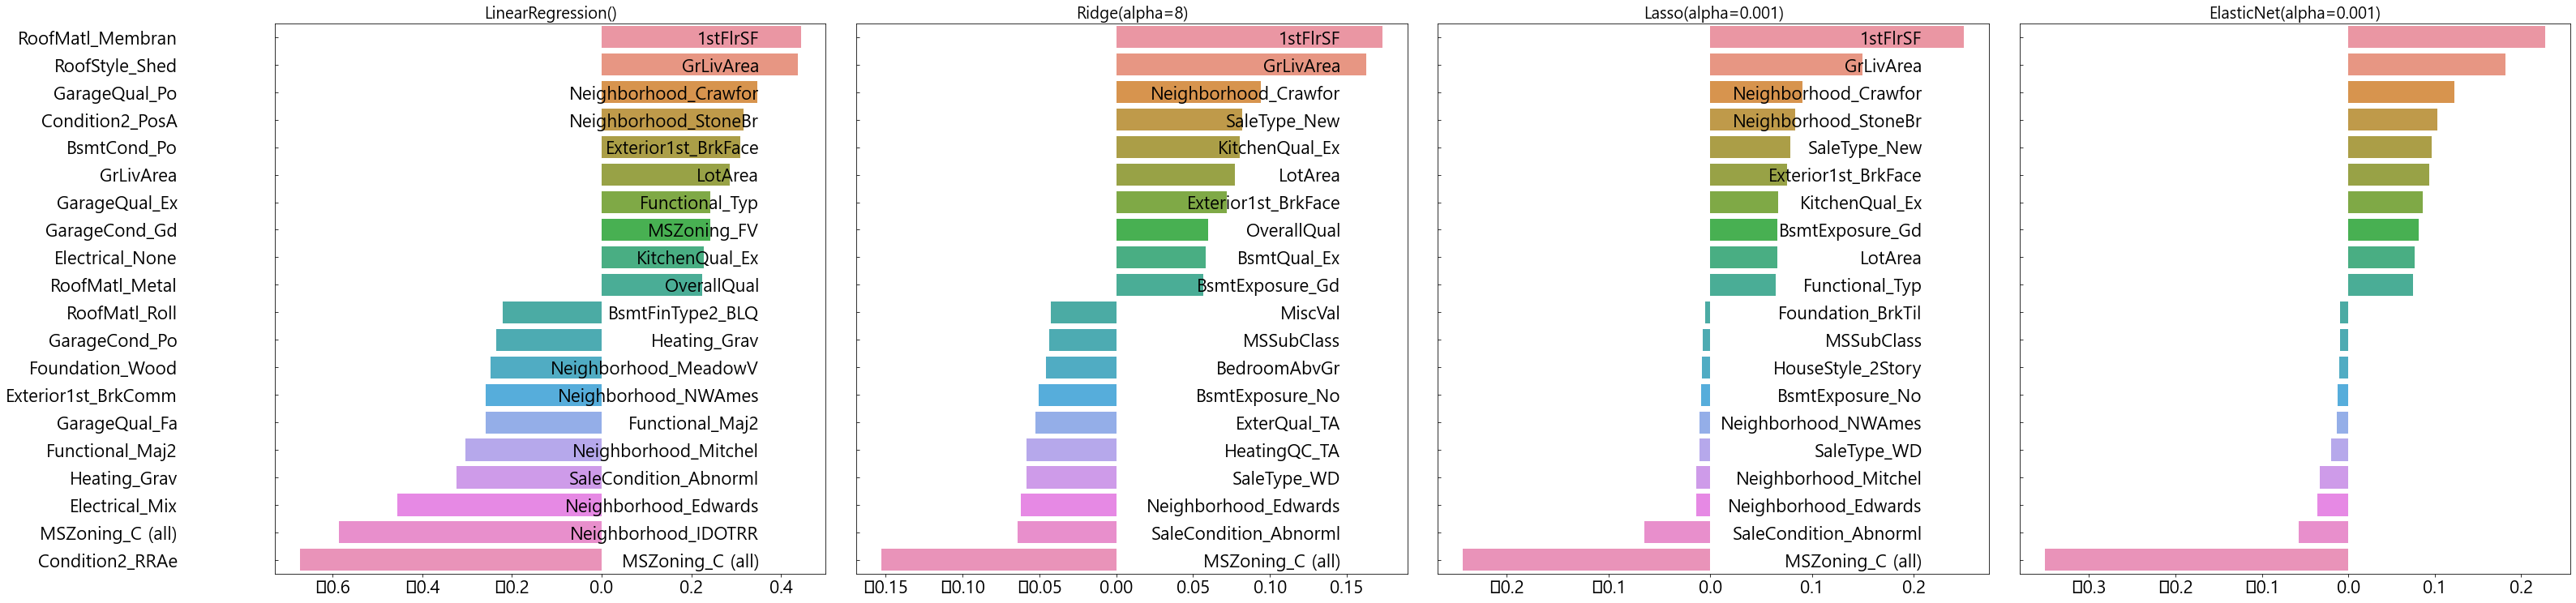

In [21]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

elastic_reg = ElasticNet(alpha=0.001)
elastic_reg.fit(X_train,y_train)

# 시각화 결과 출력
model = [lr_reg,ridge_reg,lasso_reg,elastic_reg]
visualize_coef(model)

# 성능평가지표 출력
for model in model:
    get_model_predict(model,X_train, X_test, y_train, y_test, is_expm1=True)

* 이상치를 제거함으로서 모델의 성능이 상당히 우수해졌다.

# 5. 회귀트리 모델 구축 - XGBoost, LightGBM

In [23]:
from xgboost import XGBRegressor

xgb_param = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_param(xgb_reg, xgb_param)

XGBRegressor 5CV 시 최적 평균 RMSLE값 : 0.1183,최적 ALPHA : {'n_estimators': 1000}


In [25]:
from lightgbm import LGBMRegressor

lgbm_param = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_param(lgbm_reg, lgbm_param)

LGBMRegressor 5CV 시 최적 평균 RMSLE값 : 0.1167,최적 ALPHA : {'n_estimators': 1000}


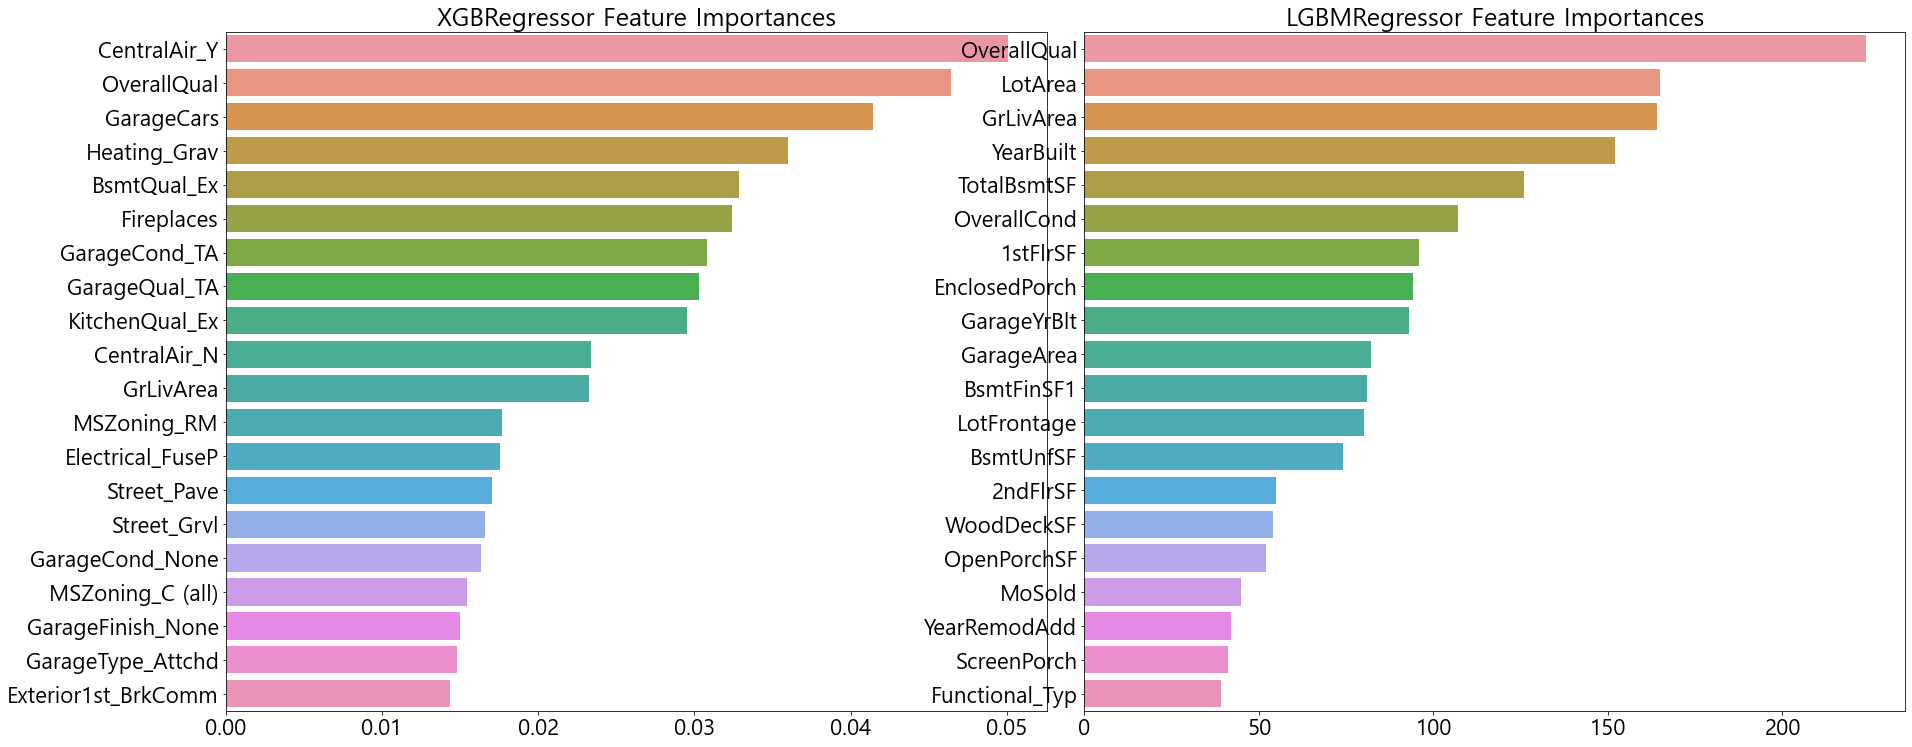

In [26]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 get_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)


# 6. 스태킹 앙상블을 통한 회귀모델 구축

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [28]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)


Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [31]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', round(rmse,4))

스태킹 회귀 모델의 최종 RMSE 값은: 0.0981
